In [1]:
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import (
    adjusted_rand_score,
    adjusted_mutual_info_score,
    homogeneity_score,
    completeness_score,
    v_measure_score,
    silhouette_score,
)
from sklearn.model_selection import GridSearchCV

# Лабораторная работа 8

Кластеризация

Выполнил: гр. 6132, Габбасов Раиль

0 Найти датасет для кластеризации: для этого берём датасет для мультиклассовой классификации и временно убираем метки классов. Эти метки классов пригодятся нам для оценки качества кластеризации. Хотя в реальной жизни такой роскоши скорее всего не будет, однако наличие априорного знания о кластерах позволит нам посчитать несколько дополнительных метрик. Опишите данные, что обозначает каждый столбец, какого типа (категориальный, вещественный, целочисленный, бинарный) данный столбец, при необходимости для категориальных в том числе бинарных признаков привести расшифровку их значений.

In [2]:
df = pd.read_csv('../data/pets.csv', parse_dates=[1, 2])

In [3]:
df = df.dropna()

In [4]:
df['pet_category'].value_counts()

2    10561
1     6601
4      158
0       37
Name: pet_category, dtype: int64

In [5]:
# df[(df.index % 20 == 0) | df['pet_category'] == 0]

In [6]:
df = df[np.logical_or(np.logical_or((df.index % 15 == 0), df['pet_category'] == 0), df['pet_category'] == 4)]

In [7]:
df['pet_category'].value_counts()

2    695
1    455
4    158
0     37
Name: pet_category, dtype: int64

In [8]:
# df = df[:2500]

In [9]:
df.dtypes

pet_id                    object
issue_date        datetime64[ns]
listing_date      datetime64[ns]
condition                float64
color_type                object
length(m)                float64
height(cm)               float64
X1                         int64
X2                         int64
breed_category           float64
pet_category               int64
dtype: object

In [10]:
# удаляем метки классов
y1 = df.pop('pet_category')

In [11]:
df1 = df.drop(columns=['pet_id', 'issue_date', 'listing_date'])

In [12]:
df1['color_type'] = pd.factorize(df1['color_type'])[0]

In [13]:
# Иерархическая кластеризация
cl = linkage(df1, 'average')

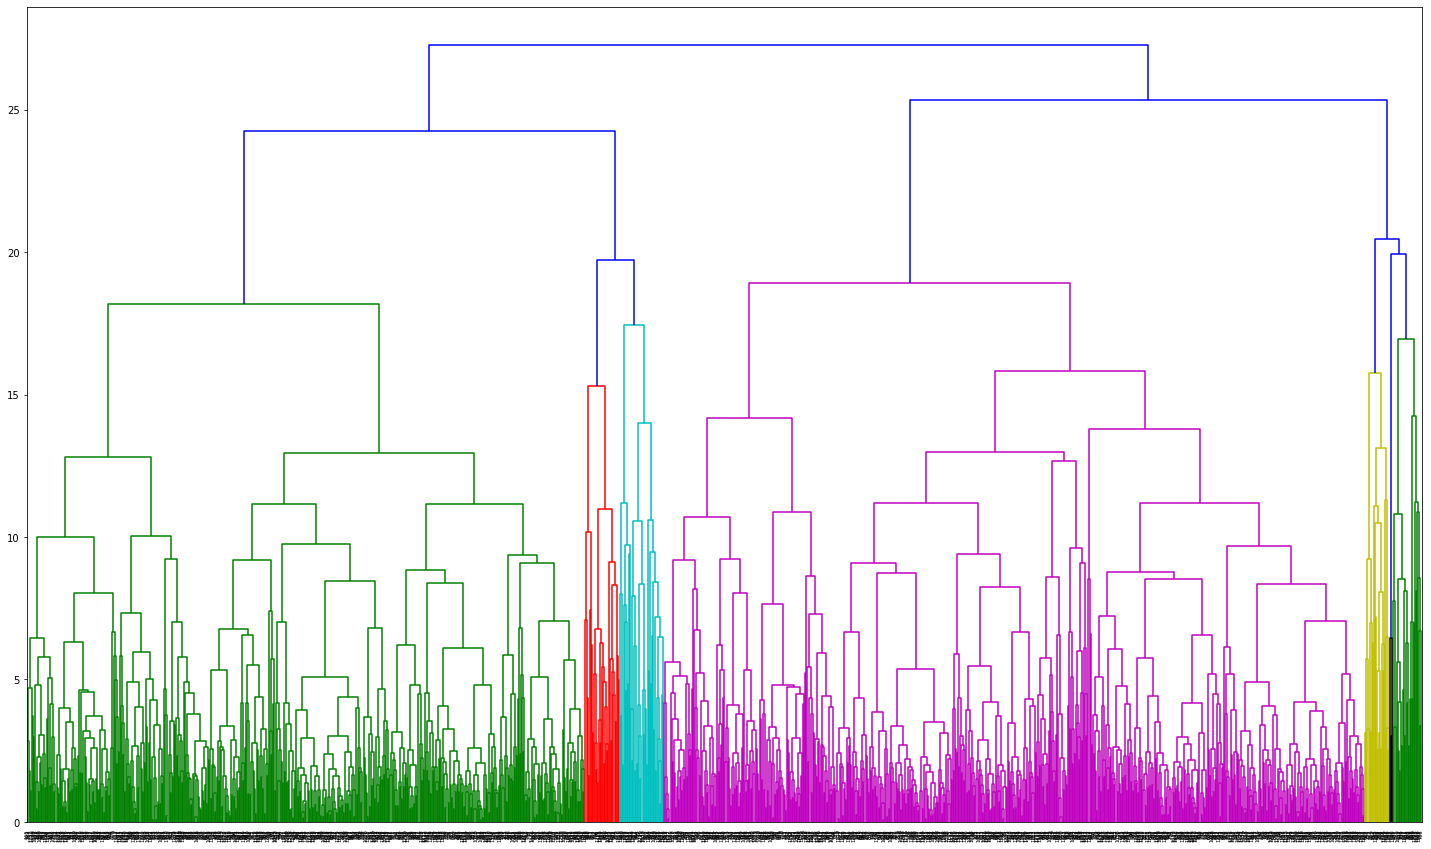

In [14]:
# дендрограмма
fig = plt.figure(figsize=(25, 15))
dn = dendrogram(cl)

2 На том же датасете выподните кластеризацию, используя любой другой метод кластеризации (пока с произвольными гиперпараметрами)

In [15]:
def metrix(X, y, algo):
    return {
        "ARI": adjusted_rand_score(y, algo.labels_),
        "AMI": adjusted_mutual_info_score(y, algo.labels_),
        "Homogeneity": homogeneity_score(y, algo.labels_),
        "Completeness": completeness_score(y, algo.labels_),
        "V-measure": v_measure_score(y, algo.labels_),
        "Silhouette": silhouette_score(X, algo.labels_)
    }

In [16]:
# используем самый простой метод - метод k-средних
n = len(y1.unique())
k_means = KMeans(n_clusters=n, max_iter=100).fit(df1)
metrix(df1, y1, k_means)

{'ARI': 0.011987156614088829,
 'AMI': 0.006743767256718049,
 'Homogeneity': 0.010541903999884042,
 'Completeness': 0.008955785690745495,
 'V-measure': 0.009684330245623667,
 'Silhouette': 0.35760408688991296}

3 Выполните оптимизацию гиперпараметров кластеризации (либо иерархической модели из п. 1, либо иной модели из п. 2, на ваш выбор; в случае иерархической кластеризации из п. 1 гиперпараметр — пороговое расстояние между центроидами, являющееся границей разбиения на кластеры). Оптимизацию выполните, используя одну из метрик качества кластеризации, для которых нам понадобится информация об исходных метках класса: Adjusted Rand Index (ARI), Adjusted Mutual Information (AMI), Гомогенность, полнота, V-мера.

In [17]:
p = {"n_clusters": range(2, n),
    "init": ["k-means++", "random"],
    "algorithm": ["auto", "full", "elkan"]}

In [18]:
m1 = GridSearchCV(KMeans(), p)

In [19]:
m1.fit(df1, y1)
metrix(df1, y1, m1.best_estimator_)

{'ARI': 0.003968517430444706,
 'AMI': 0.0010225310893585532,
 'Homogeneity': 0.0031141476614571168,
 'Completeness': 0.003447006885609915,
 'V-measure': 0.003272133998625967,
 'Silhouette': 0.37559357590683645}

4 Используя алгоритм/модель из п. 2 выполните оптимизацию гиперпараметра количества кластеров, используя "правило локтя" (анализируем график силуэта)

In [20]:
# ищем оптимальное количество кластеров по правилу правого локтя
g = []
list_k = list(range(1, 25))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(df1)
    g.append(km.inertia_)

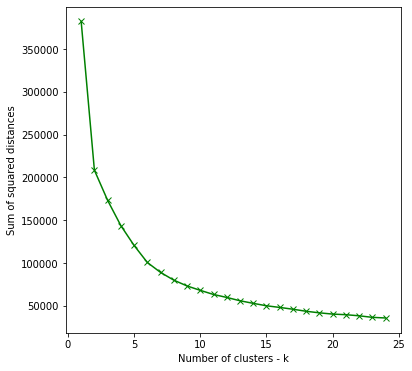

In [21]:
plt.figure(figsize=(6, 6))
plt.plot(list_k, g, '-gx')
plt.xlabel(r'Number of clusters - k')
plt.ylabel('Sum of squared distances');

На данном графике сложно определить какое количество кластеров стоит использовать, потому что кривая уменьшается монотонно и нет резкого сгиба. Оптимальное количество кластеров, которое я бы использовал, это 4 (по количеству меток) или 6 (согласно результату иерархической кластеризации).